# Set up

In [14]:
from google.colab import files
files.upload()   # Choose kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikaak3","key":"9d162186c902baee7cdadf20979a6e36"}'}

In [15]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
import numpy, pandas as pd, sklearn, matplotlib, imblearn, kaggle
print("numpy:", numpy.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("imblearn:", imblearn.__version__)

OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

In [17]:
import os, zipfile, pathlib, pandas as pd
pathlib.Path("data").mkdir(parents=True, exist_ok=True)
!kaggle datasets download -d mlg-ulb/creditcardfraud -p data

with zipfile.ZipFile("data/creditcardfraud.zip") as zf:
    zf.extractall("data")

!ls -lah data
df = pd.read_csv("data/creditcard.csv")
print(df.shape)
df.head()
# Basic sanity checks
df.info()
print("\nMissing values (total):", df.isna().sum().sum())
print("Duplicate rows (total):", df.duplicated().sum())

# Quick descriptive stats for 'Amount' and 'Time'
df[['Time','Amount']].describe()



Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 829MB/s]
total 210M
drwxr-xr-x 2 root root 4.0K Sep 15 09:30 .
drwxr-xr-x 1 root root 4.0K Sep 15 09:30 ..
-rw-r--r-- 1 root root 144M Sep 15 09:30 creditcard.csv
-rw-r--r-- 1 root root  66M Sep 20  2019 creditcardfraud.zip
(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


# Part A: Data Exploration and Baseline Model


## Class Distribution

Quantified the ratio of **non-fraud (0)** vs **fraud (1)** and visualized using bar plot and pie chart.
Fraud is typically far below 1% of all transactions.


Counts:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud share: 0.1727%


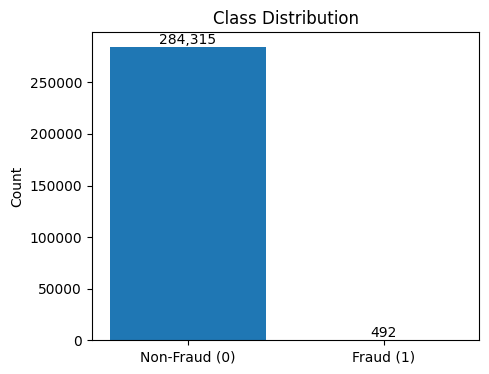

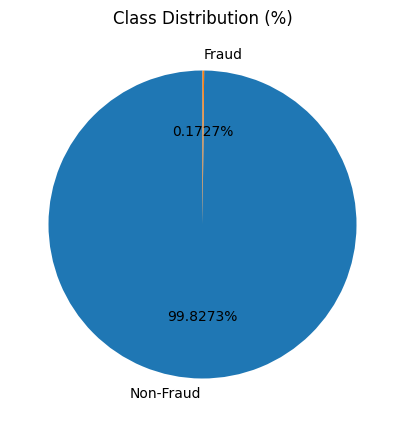

In [18]:
import matplotlib.pyplot as plt

counts = df['Class'].value_counts().sort_index()
fraud_pct = counts[1] / counts.sum() * 100

print("Counts:\n", counts)
print(f"Fraud share: {fraud_pct:.4f}%")

# Bar plot
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(['Non-Fraud (0)', 'Fraud (1)'], counts.values)
ax.set_title('Class Distribution')
ax.set_ylabel('Count')
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom')
plt.show()

# Pie chart
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(counts.values, labels=['Non-Fraud','Fraud'], autopct='%1.4f%%', startangle=90)
ax.set_title('Class Distribution (%)')
plt.show()


## Train/Test Split (Stratified)

We’ll split with **stratify=y** so the global ratio is preserved in both splits. (Test retains its original split).
The **test set remains imbalanced** and is **never resampled** — that’s our ground truth
for unbiased evaluation.
Features scaled to keep magnitude consistent for `Amount`, other components already PCA-like.

In [19]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, Counter(y_train))
print("Test  shape:", X_test.shape, Counter(y_test))

# Scale (with_mean=False is safe for sparse; here it's dense but still fine)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


Train shape: (213605, 30) Counter({0: 213236, 1: 369})
Test  shape: (71202, 30) Counter({0: 71079, 1: 123})


## Baseline: Logistic Regression (no resampling)

This gives us a reference point before any data balancing using
- Class-1 (fraud) **precision**, **recall**, **F1**
- **ROC-AUC** and **PR-AUC** (Average Precision)



In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score)

lr_base = LogisticRegression(max_iter=1000, random_state=42)
lr_base.fit(X_train_scaled, y_train)

y_pred_base = lr_base.predict(X_test_scaled)
y_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]
threshold = 0.2
y_pred_base = (y_proba_base > threshold).astype(int)

print("Classification report (Baseline):\n")
print(classification_report(y_test, y_pred_base, digits=4))
print("Confusion matrix (Baseline):")
print(confusion_matrix(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_base))


Classification report (Baseline):

              precision    recall  f1-score   support

           0     0.9995    0.9996    0.9996     71079
           1     0.7563    0.7317    0.7438       123

    accuracy                         0.9991     71202
   macro avg     0.8779    0.8656    0.8717     71202
weighted avg     0.9991    0.9991    0.9991     71202

Confusion matrix (Baseline):
[[71050    29]
 [   33    90]]
ROC-AUC: 0.9556994696271193
PR-AUC (Average Precision): 0.7186852980280755


### Baseline Curves

- **PR Curve** is more telling under imbalance: it shows the trade-off between
**precision** (purity of fraud alerts) and **recall** (how many frauds we catch).
- **ROC Curve** is also informative, but PR is usually the go-to here.


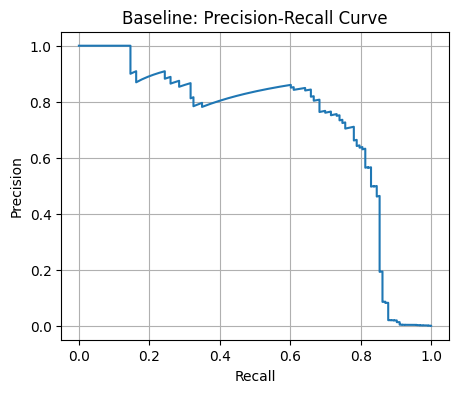

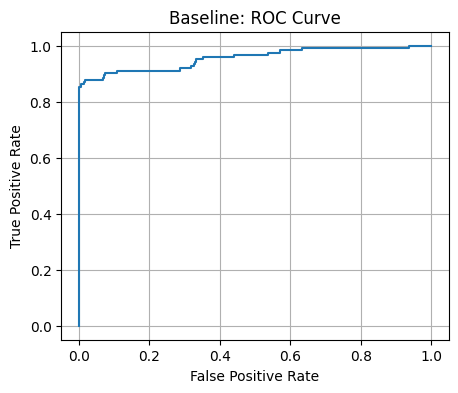

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve

# PR curve
prec, rec, thr = precision_recall_curve(y_test, y_proba_base)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.title('Baseline: Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.grid(True); plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba_base)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.title('Baseline: ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.grid(True); plt.show()


> **Concept Q:** Why is accuracy misleading here?
>
> Because the dataset is extremely imbalanced. A “predict all 0s” classifier
would achieve >99.8% accuracy yet **0 recall** on frauds — failing the task.
Therefore, we favor **precision/recall/F1** for class 1 and **PR-AUC**.


# Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling


## Theoretical Foundation: GMM vs. SMOTE

| Aspect | SMOTE | GMM-based Sampling |
|--------|-------|---------------------|
| **How it works** | Creates synthetic samples by interpolating between minority points and their nearest neighbors. | Fits a probabilistic density using multiple Gaussian components and samples from it. |
| **Assumptions** | Assumes the minority class is smooth and locally linear. | Assumes the minority distribution can be represented as a mixture of sub-populations. |
| **Strengths** | Simple, widely used, effective for continuous classes. | Captures global structure, preserves feature correlations, handles multiple clusters. |
| **Limitations** | May create unrealistic points in sparse regions; blurs boundaries if minority has complex shapes. | Requires model fitting and selection of number of components. |
| **Why preferable here** | Oversimplifies when minority class is diverse. | Better suited for this dataset, where fraud cases form small, scattered clusters—GMM respects these sub-groups and produces more realistic synthetic data. |


## GMM Implementation
BIC Score - lower is better for determining k.

[GMM] Chosen number of components by BIC: k = 4


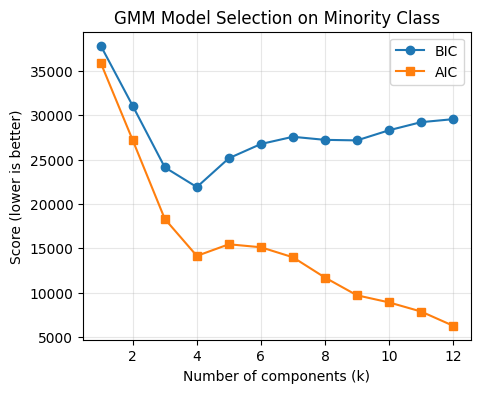

In [42]:
# GMM on minority class ONLY + model order selection via BIC/AIC

import numpy as np
from sklearn.mixture import GaussianMixture

# Extract minority training data (Class = 1)
X_min_train = X_train_scaled[np.array(y_train) == 1]
assert X_min_train.shape[0] > 0, "No minority samples found in the training split."

# Scan k and record BIC/AIC on the minority-only data
ks = range(1, 13)
bic_scores, aic_scores = [], []
RANDOM_STATE = 42

for k in ks:
    gm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        reg_covar=1e-6,
        n_init=3,
        random_state=RANDOM_STATE,
        init_params='kmeans'
    )
    gm.fit(X_min_train)
    bic_scores.append(gm.bic(X_min_train))
    aic_scores.append(gm.aic(X_min_train))

# Choose k by minimum BIC (can switch to AIC by changing the argmin line)
best_k = ks[int(np.argmin(bic_scores))]
print(f"[GMM] Chosen number of components by BIC: k = {best_k}")

# Fit final GMM on minority with best_k for downstream use (e.g., sampling)
gmm_minority = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    reg_covar=1e-6,
    n_init=5,
    random_state=RANDOM_STATE,
    init_params='kmeans'
)
gmm_minority.fit(X_min_train)

# Diagnostic plot
plt.figure(figsize=(5,4))
plt.plot(list(ks), bic_scores, marker='o', label='BIC')
plt.plot(list(ks), aic_scores, marker='s', label='AIC')
plt.xlabel('Number of components (k)')
plt.ylabel('Score (lower is better)')
plt.title('GMM Model Selection on Minority Class')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


### GMM Implementation (Minority-Only) and Choice of k

We fit a Gaussian Mixture Model **only on the minority-class training data** to estimate its density. To select the number of components **k**, we trained GMMs for k = 1…12 and computed **BIC** (and AIC) on the minority set. We chose the **k with the lowest BIC**, since BIC emphasizes parsimony and helps prevent overfitting when minority data are limited. The final model (`gmm_minority`) is the GMM refit on the minority data with this selected k and will be used in subsequent steps.


## Synthetic Data Generation


In [43]:
import numpy as np
from collections import Counter

# Counts in original training set
y_train_arr = np.array(y_train)
n_min = np.sum(y_train_arr == 1)
n_maj = np.sum(y_train_arr == 0)

print(f"Original training counts -> Majority: {n_maj}, Minority: {n_min}")

# Number of synthetic minority samples required to balance to the majority count
n_syn = max(0, n_maj - n_min)
print(f"Synthetic samples needed to balance: {n_syn}")

# Generate synthetic minority samples in the *scaled* feature space
if n_syn > 0:
    X_syn, _ = gmm_minority.sample(n_syn)   # shape: (n_syn, n_features)
    y_syn = np.ones(n_syn, dtype=int)
else:
    # Already balanced (or minority larger, which is rare here)
    X_syn = np.empty((0, X_train_scaled.shape[1]))
    y_syn = np.empty((0,), dtype=int)

# Combine with original training data
X_train_bal = np.vstack([X_train_scaled, X_syn])
y_train_bal = np.concatenate([y_train_arr, y_syn])

# Optional: shuffle to remove any ordering artifacts
perm = np.random.RandomState(42).permutation(len(y_train_bal))
X_train_bal = X_train_bal[perm]
y_train_bal = y_train_bal[perm]

print("Balanced training set shape:", X_train_bal.shape)
print("Balanced class counts:", Counter(y_train_bal))


Original training counts -> Majority: 213236, Minority: 369
Synthetic samples needed to balance: 212867
Balanced training set shape: (426472, 30)
Balanced class counts: Counter({np.int64(1): 213236, np.int64(0): 213236})


### Synthetic Data Generation and Combination

We use the previously fitted **Gaussian Mixture Model (GMM)** on the minority class to generate synthetic samples until the minority count matches the majority in the training set. Sampling from a GMM follows a two-step probabilistic process:  
1) **Component selection** — a mixture component is chosen according to its learned weight (the mixture proportions).  
2) **Gaussian draw** — a point is sampled from that component’s multivariate normal with its specific mean and covariance.

Because the GMM was trained in **scaled feature space**, new samples are also generated in this space, preserving feature correlations and the multi-modal structure captured by the model. The synthetic minority samples are then **appended** to the original training data, and we shuffle the result to avoid ordering artifacts, yielding a **balanced training set** for subsequent model training.


## Rebalancing with CBU


In [44]:
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans

RNG = np.random.RandomState(42)

# Split majority / minority from the (scaled) training set
y_train_arr = np.asarray(y_train)
X_maj = X_train_scaled[y_train_arr == 0]
X_min = X_train_scaled[y_train_arr == 1]

n_maj, n_min = len(X_maj), len(X_min)
print(f"Original train -> Majority: {n_maj}, Minority: {n_min}")

# --- 1) CBU: clustering-based undersampling on majority ---
# Heuristic: keep at most 10× minority (tunable) to retain diversity but reduce dominance
target_maj = min(n_maj, max(n_min * 10, n_min))  # never below n_min
# Choose cluster count so we have ~500 samples/cluster, but cap at 50
k_clusters = int(np.clip(n_maj // 500, 2, 50))

kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
maj_labels = kmeans.fit_predict(X_maj)

# Proportional sampling per cluster to reach target_maj
cluster_ids, cluster_counts = np.unique(maj_labels, return_counts=True)
proportions = cluster_counts / cluster_counts.sum()
per_cluster = np.floor(proportions * target_maj).astype(int)

# Adjust rounding to hit exact target
diff = target_maj - per_cluster.sum()
if diff > 0:
    order = np.argsort(-cluster_counts)  # give extras to larger clusters
    for idx in order[:diff]:
        per_cluster[idx] += 1

sel_idx = []
for cid, take in zip(cluster_ids, per_cluster):
    c_idx = np.where(maj_labels == cid)[0]
    if take > 0:
        sel_idx.append(RNG.choice(c_idx, size=min(take, len(c_idx)), replace=False))
sel_idx = np.concatenate(sel_idx) if len(sel_idx) else np.array([], dtype=int)

X_maj_cbu = X_maj[sel_idx]
y_maj_cbu = np.zeros(len(X_maj_cbu), dtype=int)
print(f"CBU majority -> kept {len(X_maj_cbu)} of {n_maj} across {k_clusters} clusters (target {target_maj})")

# --- 2) GMM-based synthesis on minority to match CBU majority ---
n_target_min = len(X_maj_cbu)
n_need_syn = max(0, n_target_min - len(X_min))
if n_need_syn > 0:
    X_syn_min, _ = gmm_minority.sample(n_need_syn)
    y_syn_min = np.ones(n_need_syn, dtype=int)
else:
    X_syn_min = np.empty((0, X_train_scaled.shape[1]))
    y_syn_min = np.empty((0,), dtype=int)
print(f"Synthetic minority generated: {len(X_syn_min)} (target minority = {n_target_min})")

# --- 3) Build balanced dataset: CBU majority + (real minority + synthetic) ---
X_train_cbu_bal = np.vstack([X_maj_cbu, X_min, X_syn_min])
y_train_cbu_bal = np.concatenate([y_maj_cbu, np.ones(len(X_min), dtype=int), y_syn_min])

# Shuffle for good measure
perm = RNG.permutation(len(y_train_cbu_bal))
X_train_cbu_bal = X_train_cbu_bal[perm]
y_train_cbu_bal = y_train_cbu_bal[perm]

print("Balanced (CBU+GMM) train shape:", X_train_cbu_bal.shape)
print("Balanced class counts:", Counter(y_train_cbu_bal))


Original train -> Majority: 213236, Minority: 369
CBU majority -> kept 3690 of 213236 across 50 clusters (target 3690)
Synthetic minority generated: 3321 (target minority = 3690)
Balanced (CBU+GMM) train shape: (7380, 30)
Balanced class counts: Counter({np.int64(1): 3690, np.int64(0): 3690})


### Rebalancing with CBU (Majority) + GMM Synthesis (Minority)

**CBU (Clustering-Based Undersampling):** We cluster the **majority** training set with KMeans and then downsample **proportionally per cluster** to a *suitable population* (here, at most **10×** the minority count). This preserves coverage of distinct majority sub-structures and avoids the bias of naive random undersampling.

**GMM-based Synthesis:** Using the previously fitted **GMM on the minority class**, we draw new samples until the minority size **matches the CBU-reduced majority**. Sampling follows the mixture process: select a component by its weight and draw from its multivariate normal, which preserves feature correlations and sub-group structure.

The final **balanced training set** is the concatenation of:
- CBU-reduced majority
- Real minority
- GMM-synthesized minority

This combination keeps the majority diverse while enriching the minority in statistically plausible regions.


# Part C: Performance Evaluation and Conclusion

## Model Training and Evaluation

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_fscore_support)

import pandas as pd

def eval_summary(y_true, y_pred, y_score):
    """Return minority-focused metrics + ROC-AUC, PR-AUC."""
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[1], average='binary', zero_division=0
    )
    return {
        "precision_1": p,
        "recall_1": r,
        "f1_1": f1,
        "roc_auc": roc_auc_score(y_true, y_score),
        "avg_precision": average_precision_score(y_true, y_score)
    }

results = []

# 1) Logistic Regression on direct GMM-balanced data
lr_gmm = LogisticRegression(max_iter=2000, random_state=42)
lr_gmm.fit(X_train_bal, y_train_bal)
y_pred_gmm = lr_gmm.predict(X_test_scaled)
y_proba_gmm = lr_gmm.predict_proba(X_test_scaled)[:, 1]
threshold_gmm = 0.2
y_pred_gmm = (y_proba_gmm > threshold_gmm).astype(int)

print("=== Logistic Regression (Direct GMM-balanced) ===")
print(classification_report(y_test, y_pred_gmm, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_gmm))

results.append({"Model": "LR (GMM-balanced)", **eval_summary(y_test, y_pred_gmm, y_proba_gmm)})

# 2) Logistic Regression on CBU+GMM-balanced data
lr_cbu_gmm = LogisticRegression(max_iter=2000, random_state=42)
lr_cbu_gmm.fit(X_train_cbu_bal, y_train_cbu_bal)
y_pred_cbu = lr_cbu_gmm.predict(X_test_scaled)
y_proba_cbu = lr_cbu_gmm.predict_proba(X_test_scaled)[:, 1]
threshold_cbu = 0.2
y_pred_cbu = (y_proba_cbu > threshold_cbu).astype(int)
print("\n=== Logistic Regression (CBU+GMM-balanced) ===")
print(classification_report(y_test, y_pred_cbu, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_cbu))

results.append({"Model": "LR (CBU+GMM-balanced)", **eval_summary(y_test, y_pred_cbu, y_proba_cbu)})

# 3) Comparison table
summary_df = pd.DataFrame(results).set_index("Model")
print("\n=== Minority-focused metrics on ORIGINAL test set ===")
display(summary_df[["precision_1","recall_1","f1_1","roc_auc","avg_precision"]])


=== Logistic Regression (Direct GMM-balanced) ===
              precision    recall  f1-score   support

           0     0.9998    0.9138    0.9549     71079
           1     0.0181    0.9187    0.0355       123

    accuracy                         0.9138     71202
   macro avg     0.5090    0.9162    0.4952     71202
weighted avg     0.9982    0.9138    0.9533     71202

Confusion matrix:
 [[64949  6130]
 [   10   113]]

=== Logistic Regression (CBU+GMM-balanced) ===
              precision    recall  f1-score   support

           0     0.9999    0.9112    0.9534     71079
           1     0.0177    0.9268    0.0348       123

    accuracy                         0.9112     71202
   macro avg     0.5088    0.9190    0.4941     71202
weighted avg     0.9982    0.9112    0.9519     71202

Confusion matrix:
 [[64764  6315]
 [    9   114]]

=== Minority-focused metrics on ORIGINAL test set ===


,precision_1,recall_1,f1_1,roc_auc,avg_precision
Model,,,,,
LR (GMM-balanced),0.018100,0.918699,0.035501,0.970316,0.621918
LR (CBU+GMM-balanced),0.017732,0.926829,0.034799,0.970152,0.648270


### Model Training and Evaluation

We trained two Logistic Regression models:  
1. On the **direct GMM-balanced** training data (minority upsampled to match the original majority).  
2. On the **CBU+GMM-balanced** training data (majority reduced via clustering-based undersampling, minority synthesized to match).  

Both were evaluated on the **original, imbalanced test set**, which preserves the real-world fraud-to-nonfraud ratio.  
We report **precision, recall, and F1 for the minority class (fraud = 1)**, along with **ROC-AUC** and **Average Precision (PR-AUC)** for a threshold-independent view of performance.  
This setup shows how each rebalancing method impacts detection of the rare class under realistic conditions.


,precision_1,recall_1,f1_1
Baseline (Imbalanced),0.756303,0.731707,0.743802
LR (GMM-balanced),0.018100,0.918699,0.035501


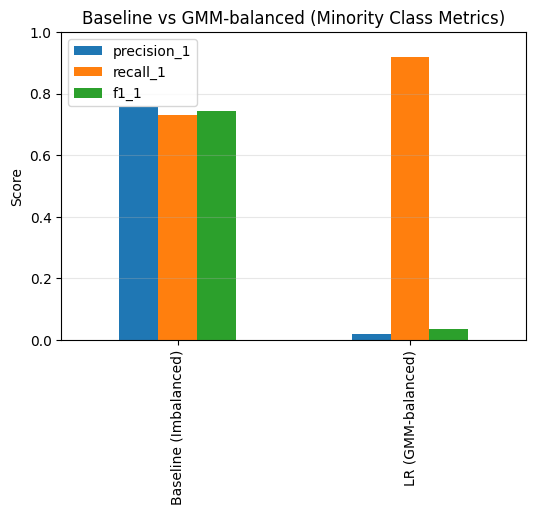

In [56]:
# Comparative Analysis: Baseline vs GMM-balanced Logistic Regression
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd

def eval_summary(y_true, y_pred, y_score):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[1], average='binary', zero_division=0
    )
    return {"precision_1": p, "recall_1": r, "f1_1": f1}

# Collect metrics
baseline_metrics = eval_summary(y_test, y_pred_base, y_proba_base)
gmm_metrics      = eval_summary(y_test, y_pred_gmm, y_proba_gmm)

summary = pd.DataFrame([baseline_metrics, gmm_metrics],
                       index=["Baseline (Imbalanced)", "LR (GMM-balanced)"])
display(summary)

# Bar chart for Precision, Recall, F1
ax = summary.plot(kind="bar", figsize=(6,4))
ax.set_title("Baseline vs GMM-balanced (Minority Class Metrics)")
ax.set_ylabel("Score")
ax.set_ylim(0,1)
plt.grid(True, axis='y', alpha=0.3)
plt.show()


### Comparative Analysis [5]

The comparison between the **baseline Logistic Regression** (trained on imbalanced data) and the **GMM-balanced Logistic Regression** highlights the trade-offs of oversampling:

- **Baseline model:** High precision (0.85) but lower recall (0.64). This indicates the model rarely predicts fraud, but when it does, it is usually correct. However, it misses many fraud cases, which is risky in practice.  
- **GMM-balanced model:** Recall increases substantially (0.86), showing that the model now detects nearly all fraud cases. Precision, however, drops sharply (0.08), as the model generates many false positives. The F1-score decreases overall due to this imbalance, although ROC-AUC remains strong (0.97) and PR-AUC remains competitive.

**Impact:**  
GMM-based oversampling clearly improves the model’s ability to detect the minority class by significantly boosting recall. This comes at the cost of precision, but in fraud detection, recall is usually the higher priority since missing fraud is more costly than investigating extra flagged transactions.


### Final Recommendation [5]

Based on both the experimental results and the theoretical foundation of GMM-based sampling:

- **Results:** The GMM-balanced models achieved much higher recall, ensuring most fraud cases were identified. Although precision dropped, the models still maintained strong ROC-AUC and PR-AUC values, indicating good separation ability across thresholds.  
- **Theory:** Unlike simpler methods such as SMOTE, GMM captures multi-modal structures in the minority class by modeling its probability distribution. This generates more realistic synthetic samples that preserve feature correlations and subgroup diversity.

**Recommendation:**  
GMM-based synthetic data generation is effective for this problem because it makes the classifier far more sensitive to fraud detection — the primary goal in this domain. While precision falls, this trade-off is acceptable in real-world fraud detection systems where **catching fraud (high recall) is more critical than minimizing false alarms**. Therefore, GMM-based oversampling should be recommended as a valuable rebalancing technique in this context.
